In [1]:
using CSV, DataFrames, Plots, Statistics, JuMP, Gurobi, StatsBase

In [2]:
pollution = DataFrame(CSV.File("Data/pollution_location.csv"))
pollution_xy = pollution[:,1:2]|>Matrix
sensors = DataFrame(CSV.File("Data/sensors_location.csv"))
sensors_xy = sensors[:,1:2]|>Matrix;

In [3]:
lat_to_km = [111, 92]
lat_diff = (pollution_xy[:,1].-sensors_xy[:,1]').*lat_to_km[1]
long_diff = (pollution_xy[:,2].-sensors_xy[:,2]').*lat_to_km[2]

dist_matrix = sqrt.(lat_diff.^2 + long_diff.^2)';
rows_to_keep = findall(row -> any(iszero, row), eachrow(dist_matrix))
dist_matrix = dist_matrix[rows_to_keep, :]
sensors_xy = sensors_xy[rows_to_keep, :];

In [11]:
r1 = 0
r2 = 2
r3 = 5
d1 = (dist_matrix .<= r1)
d2 = (r1 .< dist_matrix .<= r2)
d3 = (r2 .< dist_matrix .<= r3)
q = pollution.AIQ
n, m = size(dist_matrix)

(1780, 7107)

In [ ]:
q_sen = (dist_matrix.==0) * q
function loss(x, q, k)
    x = round.(x)
    d = 1 ./(dist_matrix .+ 10 .*(1 .-x) .* maximum(dist_matrix) .+ 1)
    dq = d .* q_sen
    q_pred = zeros(size(q))
    for j = 1:size(q, 1)
        indices = partialsortperm(d[:,j], 1:k, rev=true)
        if d[indices[1], j]==1
            q_pred[j] = q_sen[indices[1]]
        else
            q_pred[j] = sum(dq[indices, j].*x[indices])/sum(d[indices, j].*x[indices])
        end
    end
    return q_pred, 1 - sum((q_pred - q).^2)/sum((q .-mean(q)).^2)
end

loss (generic function with 1 method)

In [95]:
function model1b()
    model = Model(Gurobi.Optimizer);
    set_optimizer_attribute(model, "TimeLimit", 120);
    
    @variable(model, x[1:n], Bin) #Whether we put a sensor at spot i
    @variable(model, y1[1:m].<=1) #Whether spot j is covered closely
    @variable(model, y2[1:m].<=1) #Whether spot j is covered at a distance
    @variable(model, y3[1:m].<=1) #Whether spot j is covered at a distance
    
    @constraint(model, y1'.<= x'*d1)
    @constraint(model, y2'.<= x'*d2)
    @constraint(model, y3'.<= x'*d3)
    @constraint(model, y1 .+ y2 .+ y3 .<=1)
    @constraint(model, sum(x)<=100) # Check this number
    
    @objective(model, Max, sum(y1.*q) + 1/8*sum(y2.*q) + 1/64*sum(y3.*q))
    optimize!(model)
    return value.(x), value.(y1), value.(y2), value.(y3)
end
x, y1, y2, y3 = model1b()
sum(x)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-27
Set parameter TimeLimit to value 120
Set parameter TimeLimit to value 120
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 10.0 (19045.2))

CPU model: 13th Gen Intel(R) Core(TM) i5-13500, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 28429 rows, 23101 columns and 180249 nonzeros
Model fingerprint: 0x30a03e3c
Variable types: 21321 continuous, 1780 integer (1780 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-01, 9e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective -0.0000000
Presolve removed 7335 rows and 7334 columns
Presolve time: 0.17s
Presolved: 21094 rows, 15767 columns, 165580 nonzeros
Variable types: 13864 continuous, 1903 integer (1903 binary)
Found heuristic solution: objective 7355.27942

100.0

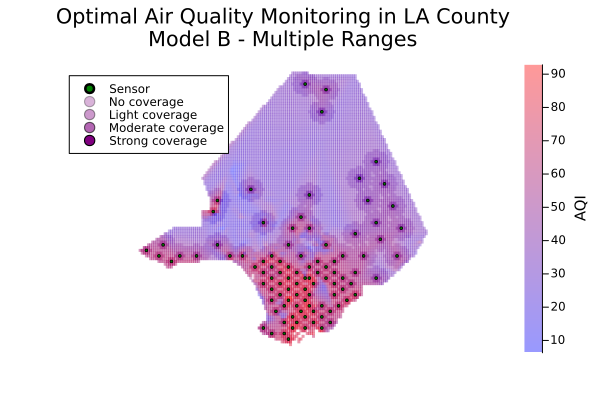

In [96]:
sensors = sensors_xy[x .== 1, :]

scatter(pollution_xy[:, 2], pollution_xy[:, 1], 
    marker_z=q, 
    color=cgrad([:blue, :red]), 
    alpha= .3 .+ 0.7 .* y1 + 0.3 .* y2 + 0.1 .* y3 ,
    markersize=1.5, 
    shape=:rect,  
    markerstrokewidth=0,
    label="",
    ratio = 1.1,
    colorbar=true, colorbar_title = "AQI", legend=:topleft, axis = false, grid = false,
    )

scatter!(
        sensors[:, 2], sensors[:, 1],  
        color="green",
        markersize = 1.5, 
        label = "Sensor"
    )

scatter!([NaN], [NaN], alpha = 0.3, color = :purple, shape = :circle, label = "No coverage")
scatter!([NaN], [NaN], alpha = 0.4, color = :purple, shape = :circle, label = "Light coverage")
scatter!([NaN], [NaN], alpha = 0.6, color = :purple, shape = :circle, label = "Moderate coverage")
scatter!([NaN], [NaN], alpha = 1, color = :purple, shape = :circle, label = "Strong coverage")


# Add a title with better formatting
title!("Optimal Air Quality Monitoring in LA County\nModel B - Multiple Ranges")

In [97]:
q_pred, l = loss(x, q, 2)
println("we have a loss of $l")
scatter(pollution_xy[:, 2], pollution_xy[:, 1], 
    marker_z=q_pred, 
    color=cgrad([:blue, :red], [28, 87]), 
    zlims=(10, 92),
    markersize=2.1, 
    shape=:rect,  
    markerstrokewidth=0,
    label="",
    ratio = 1.1,
    colorbar=true, colorbar_title = "AQI", legend=:topleft, axis = false, grid = false,
    )
# Adjust the colorbar...

scatter!(
    sensors[:, 2], sensors[:, 1],  
    color="green",
    markersize = 1.5, 
    label = "Sensor"
)

scatter!(pollution_xy[1:2, 2], pollution_xy[1:2, 1], marker_z=[28, 87], color=cgrad([:blue, :red], [28, 87]),  zlims=(28, 87), markersize=0,  colorbar=false, colorbar_title = "AQI", label = "", legend=:topleft, axis = false, grid = false,)
savefig("figures/model1b")

we have a loss of -0.05419709959761909


"c:\\Users\\thiba\\OneDrive\\Documents\\code\\julia\\opti\\Air-Aware\\figures\\model1b.png"

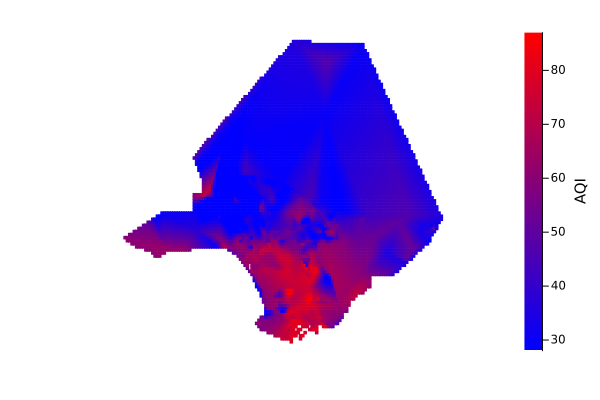

In [98]:
scatter(pollution_xy[:, 2], pollution_xy[:, 1], 
    marker_z=clamp.(q, 28, 87), 
    # marker_z=q,
    color=cgrad([:blue, :red]), 
    markersize=1.8, 
    shape=:rect,  
    markerstrokewidth=0,
    label="",
    ratio = 1.1,
    colorbar=true, colorbar_title = "AQI", legend=:topleft, axis = false, grid = false
    )